## Preparation & Load Data

In [1]:
import pandas as pd
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
versandadressen = pickle.load(open('versandadressen_clean.pkl', 'rb'))
buchungen = pd.read_pickle('buchungen_clean.pkl')

In [3]:
# remove duplicated entries
buchungen.drop_duplicates(inplace=True)
for key, dat in versandadressen.items():
    dat.drop_duplicates(subset=['newKey'],inplace=True)

In [4]:
versandadressen['v1_fruehbucher'].loc[versandadressen['v1_fruehbucher'].duplicated(subset='newKey',keep=False)]

,quelle,mediacode,name1,name2,adresse1,plz,ort,nix,name1_clean,nachname_clean,adresse1_clean,strasse_clean,hausnr_clean,plz_clean,ort_clean,newKey


In [5]:
versandadressen['v1_fruehbucher'].newKey.unique().shape[0]

19793

In [6]:
buchungen.dropna(subset=['newKey'], inplace=True)

In [7]:
# order mailings according to their dates
ordered_by_date = ['v1_fruehbucher','e2_norwegen','e4_schweden','v2_katalogbestellkarte','e1_daenemark',
                  'e3_rbKunden','v6_norwegen','v5_nordsee','v7_ostsee','v8_schweden', 'v3_dtl','v4_lastMin']

versandadressen_ordered_by_date = {}
for item in ordered_by_date:
    versandadressen_ordered_by_date[item] = versandadressen[item]

In [8]:
sum(versandadressen['v1_fruehbucher'].duplicated())


0

In [9]:
versandadressen['v1_fruehbucher'].loc[versandadressen['v1_fruehbucher'].newKey=='haberlandt fuchsbau23 29331lachendorf']

,quelle,mediacode,name1,name2,adresse1,plz,ort,nix,name1_clean,nachname_clean,adresse1_clean,strasse_clean,hausnr_clean,plz_clean,ort_clean,newKey
8932,Frühbucher,2016DKWWW,Jens Haberlandt,NaN,Amfuchsbau 23,29331,Lachendorf,NaN,jens haberlandt,haberlandt,fuchsbau 23,fuchsbau,23,29331,lachendorf,haberlandt fuchsbau23 29331lachendorf


In [10]:
repl_dic={
    'v1_fruehbucher':'DM:Frühbucher',
 'e2_norwegen':'EV:Norwegen',
 'e4_schweden':'EV:Schweden',
 'v2_katalogbestellkarte':'DM:Katalogbestellkarte',
 'e1_daenemark':'EV:Dänemark',
 'e3_rbKunden':'EV:RB-Kunden',
 'v6_norwegen':'DM:Norwegen',
 'v5_nordsee':'DM:Nordsee',
 'v7_ostsee':'DM:Ostsee',
 'v8_schweden':'DM:Schweden',
 'v3_dtl':'DM:Deutschland',
 'v4_lastMin':'DM:LastMinute',
 'e5_deutschland': 'EV:Deutschland'}

for key in ordered_by_date:
    
    print(repl_dic[key],',' ,versandadressen[key].newKey.unique().shape[0])

DM:Frühbucher , 19793
EV:Norwegen , 2111
EV:Schweden , 1748
DM:Katalogbestellkarte , 55205
EV:Dänemark , 4890
EV:RB-Kunden , 3882
DM:Norwegen , 19836
DM:Nordsee , 56957
DM:Ostsee , 56957
DM:Schweden , 12113
DM:Deutschland , 11787
DM:LastMinute , 48510


## Daten zusammenführen

In [11]:
for key, dat in versandadressen_ordered_by_date.items():
    dat['newKey'] = dat['newKey'].fillna('missing')

for key, dat in versandadressen_ordered_by_date.items():
    buchungen = pd.merge(buchungen, dat[['newKey','name1','mediacode']], how='left', on=['newKey'])
    # is there a mailing?
    buchungen.loc[-pd.isnull(buchungen['name1']),'name1'] = 1
    buchungen.loc[pd.isnull(buchungen['name1']),'name1'] = 0
    # corresponding mediacode^
    colname = key+'_mediacode'
    buchungen.rename(columns={'name1':key,'mediacode':colname}, inplace=True)


## Response Analyse

In [12]:
mailing_dates = [
                datetime.date(2016, 6, 1),
                datetime.date(2016, 10, 12),
                datetime.date(2016, 10, 12),
                datetime.date(2016, 11, 16),
                datetime.date(2016, 11, 23),
                datetime.date(2017, 1, 11),
                datetime.date(2017, 1, 11),
                datetime.date(2017, 1, 18),
                datetime.date(2017, 2, 8),
                datetime.date(2017, 2, 22),
                datetime.date(2017, 3, 8),
                datetime.date(2017, 5, 31),
                ]

sending_ordered_by_date = ['v1_fruehbucher','e2_norwegen','e4_schweden','v2_katalogbestellkarte','e1_daenemark',
                  'e3_rbKunden','v6_norwegen','v5_nordsee','v7_ostsee','v8_schweden', 'v3_dtl','v4_lastMin']

In [13]:
def which_last_mailing(dat):
    for idx, sending in enumerate(sending_ordered_by_date):
        if dat[sending]==1:
            if (dat['Datum'].to_pydatetime().date() - mailing_dates[idx]).days>0:
                return sending
    return 'Buchung vor Erstkontakt'

def which_mediacode(dat):
    for idx, sending in enumerate(sending_ordered_by_date):
        if dat[sending]==1:
            if (dat['Datum'].to_pydatetime().date() - mailing_dates[idx]).days>0:
                return dat[sending+'_mediacode']
    return 'Buchung vor Erstkontakt'
        
def timeDiff_btw_booking_last_mailing(dat):
    for idx, sending in enumerate(sending_ordered_by_date):
        if dat[sending]==1:
            if (dat['Datum'].to_pydatetime().date() - mailing_dates[idx]).days>0:
                return (dat['Datum'].to_pydatetime().date() - mailing_dates[idx]).days
    return np.nan
        
def numberOfMailings_untilBooking(dat):
    numberOfMailings = 0
    for idx, sending in enumerate(sending_ordered_by_date):
        if dat[sending]==1:
            numberOfMailings += 1
            if (dat['Datum'].to_pydatetime().date() - mailing_dates[idx]).days:
                return numberOfMailings            
    return numberOfMailings

In [14]:
buchungen['last_mailing'] = buchungen.apply(which_last_mailing ,axis=1)
buchungen['last_mailing_mediacode'] = buchungen.apply(which_mediacode, axis=1)
buchungen['timeDiff_btw_booking_last_mailing'] = buchungen.apply(timeDiff_btw_booking_last_mailing ,axis=1)
buchungen['number_of_mailings_until_booking'] = buchungen.apply(numberOfMailings_untilBooking ,axis=1)
buchungen['number_of_total_mailings'] = buchungen.apply(lambda x: sum(x.loc[sending_ordered_by_date]), axis=1)

In [15]:
# Korrekte Differenzbildung bei den Dates
buchungen_w_mailing_only = buchungen.loc[buchungen.number_of_total_mailings>0].copy()
buchungen_w_mailing_only.groupby('last_mailing').size()

last_mailing
Buchung vor Erstkontakt    1441
e1_daenemark                177
e2_norwegen                 185
e3_rbKunden                 219
e4_schweden                 116
v1_fruehbucher             4104
v2_katalogbestellkarte     2365
v3_dtl                       12
v4_lastMin                   15
v5_nordsee                  166
v6_norwegen                 117
dtype: int64

In [16]:
# Falsche Differenzbildung bei den Dates
buchungen_w_mailing_only = buchungen.loc[buchungen.number_of_total_mailings>0].copy()
buchungen_w_mailing_only.groupby('last_mailing').size()

last_mailing
Buchung vor Erstkontakt    1441
e1_daenemark                177
e2_norwegen                 185
e3_rbKunden                 219
e4_schweden                 116
v1_fruehbucher             4104
v2_katalogbestellkarte     2365
v3_dtl                       12
v4_lastMin                   15
v5_nordsee                  166
v6_norwegen                 117
dtype: int64

In [17]:
buchungen_w_mailing_only.head(10)

,Datum,Buchungsnummer,Kundennummer,MIETE,Hausnation,Name1,Name2,Adresse1,Adresse2,LKZ,...,v8_schweden_mediacode,v3_dtl,v3_dtl_mediacode,v4_lastMin,v4_lastMin_mediacode,last_mailing,last_mailing_mediacode,timeDiff_btw_booking_last_mailing,number_of_mailings_until_booking,number_of_total_mailings
0,2016-07-05,100003,3355207,1246,DK,Heiner Warzecha,NaN,Laubstr. 24,NaN,D,...,NaN,0,NaN,0,NaN,v1_fruehbucher,2016DKAS400,34.0,1,3
5,2016-07-05,100012,3482431,1123,DK,"Roth, Rolf",NaN,Reistert 14,NaN,D,...,2017KANO,1,2017KADE,1,2017KADK,v1_fruehbucher,2016DKAS400,34.0,1,9
6,2016-07-05,100013,3482431,1123,DK,"Roth, Rolf",NaN,Reistert 14,NaN,D,...,2017KANO,1,2017KADE,1,2017KADK,v1_fruehbucher,2016DKAS400,34.0,1,9
7,2016-07-05,100015,3484083,436,DK,"Bichlmaier, Heinz",NaN,Georgistrasse 2,NaN,D,...,NaN,0,NaN,0,NaN,v1_fruehbucher,2016DKAS400,34.0,1,5
16,2016-07-05,100046,3790033,1106,N,Lothar Leonhardt,NaN,Bergmannsglück 86b,NaN,D,...,2015NWWW,0,NaN,0,NaN,Buchung vor Erstkontakt,Buchung vor Erstkontakt,NaN,1,3
17,2016-07-05,100049,3790945,776,DK,"Kiefer, Holger",NaN,Ludwig-Braille-Straße 10,NaN,D,...,NaN,0,NaN,0,NaN,Buchung vor Erstkontakt,Buchung vor Erstkontakt,NaN,1,3
18,2016-07-05,100053,3791899,637,DK,Ulrich Schmidt,NaN,Springstr. 23,NaN,D,...,NaN,0,NaN,0,NaN,v1_fruehbucher,2016DKWWW,34.0,1,4
20,2016-07-05,100069,3796148,2683,DK,Jan Remmer ter Haseborg,NaN,Am Interessentenforst 8,NaN,D,...,NaN,0,NaN,1,2015DKWWW,Buchung vor Erstkontakt,Buchung vor Erstkontakt,NaN,1,4
21,2016-07-05,100070,3622312,1038,DK,Doris Kolbe,NaN,Köpenicker Straße 296,NaN,D,...,NaN,0,NaN,1,2016DKAS400,v1_fruehbucher,2016DKAS400,34.0,1,6
22,2016-07-05,100074,3945280,296,DK,Emilia Neff,NaN,Uhlenweg 30b,NaN,D,...,NaN,0,NaN,1,2017KADK,Buchung vor Erstkontakt,Buchung vor Erstkontakt,NaN,1,4


## Export Data

In [18]:
print(buchungen.shape)
print(buchungen_w_mailing_only.shape)

print(sum(buchungen.duplicated()))
print(sum(buchungen_w_mailing_only.duplicated()))



(51745, 55)
(8917, 55)
0
0


In [19]:
buchungen_w_mailing_only.columns.values

array(['Datum', 'Buchungsnummer', 'Kundennummer', 'MIETE', 'Hausnation',
       'Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'Buchungskanal', 'Direkt_Büro', 'Name1_repl', 'Name2_repl',
       'Adresse1_repl', 'Adresse2_repl', 'Ort_repl', 'vorname_clean',
       'nachname_clean', 'strasse_clean', 'hausnr_clean', 'ort_clean',
       'plz_clean', 'newKey', 'v1_fruehbucher',
       'v1_fruehbucher_mediacode', 'e2_norwegen', 'e2_norwegen_mediacode',
       'e4_schweden', 'e4_schweden_mediacode', 'v2_katalogbestellkarte',
       'v2_katalogbestellkarte_mediacode', 'e1_daenemark',
       'e1_daenemark_mediacode', 'e3_rbKunden', 'e3_rbKunden_mediacode',
       'v6_norwegen', 'v6_norwegen_mediacode', 'v5_nordsee',
       'v5_nordsee_mediacode', 'v7_ostsee', 'v7_ostsee_mediacode',
       'v8_schweden', 'v8_schweden_mediacode', 'v3_dtl',
       'v3_dtl_mediacode', 'v4_lastMin', 'v4_lastMin_mediacode',
       'last_mailing', 'last_mailing_mediacode',
       'timeDiff_btw_b

In [20]:
export_data = buchungen_w_mailing_only.loc[:,[
       'Datum', 'Buchungsnummer', 'Kundennummer', 'MIETE', 'Hausnation',
       'Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'Buchungskanal', 'Direkt_Büro',
       'last_mailing','last_mailing_mediacode', 'timeDiff_btw_booking_last_mailing',
       'number_of_mailings_until_booking', 'number_of_total_mailings'
]]

In [21]:
# rename entries in last_mailing column

repl_dic={
    'v1_fruehbucher':'DM:Frühbucher',
 'e2_norwegen':'EV:Norwegen',
 'e4_schweden':'EV:Schweden',
 'v2_katalogbestellkarte':'DM:Katalogbestellkarte',
 'e1_daenemark':'EV:Dänemark',
 'e3_rbKunden':'EV:RB-Kunden',
 'v6_norwegen':'DM:Norwegen',
 'v5_nordsee':'DM:Nordsee',
 'v7_ostsee':'DM:Ostsee',
 'v8_schweden':'DM:Schweden',
 'v3_dtl':'DM:Deutschland',
 'v4_lastMin':'DM:LastMinute',
 'e5_deutschland': 'EV:Deutschland'}

export_data.last_mailing= export_data.last_mailing.apply(lambda x: repl_dic[x] 
                                                         if x != 'Buchung vor Erstkontakt' else x)

In [22]:
# rename columns
export_data.columns = ['Datum', 'Buchungsnummer', 'Kundennummer', 'Miete', 'Hausnation',
       'Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'Buchungskanal', 'Direkt_Büro',
       'letzter Kontakt vor Buchung','Mediacode', 'Zeit zwischen Kontakt und Buchung in Tagen',
       'Anzahl der Kontakte bis zur Buchung', 'Anzahl aller Kontakte']

In [23]:
sum(export_data.duplicated())

0

In [24]:
# save_data
export_data.to_csv('response_analyse_auf_buchungsebene.csv',decimal=',',encoding='latin-1')

#### Some numbers for reporting

In [25]:
export_data.groupby('letzter Kontakt vor Buchung').size().to_csv('letzter_Kontakt_vor_Buchung.csv')
export_data.groupby('Mediacode').size().to_csv('Kundengruppe.csv')
export_data.groupby('Anzahl der Kontakte bis zur Buchung').size().to_csv('kontakte_bis_zur_buchung.csv')
export_data.groupby('Anzahl aller Kontakte').size().to_csv('gesamtanzahl_kontakte.csv')

## Buchungen zusammenführen

In [26]:
buchungen_w_mailing_only.loc['last_mailing'] = buchungen_w_mailing_only.last_mailing.apply(lambda x: repl_dic[x] 
                                                         if x != 'Buchung vor Erstkontakt' else x)
g = buchungen_w_mailing_only.groupby('newKey').size().sort_values(ascending=False)
print(g[:14])
ls=list(g.keys()[:13])


newKey
boll andrestr.15 9112chemnitz                                        51
geffken mergaustr.10 26123oldenburg                                  23
st. liboreus gemeinde bremervoerde kirchenstr.2 27432bremervoerde    21
siedow mittelstr.1c 16515oranienburg                                 19
nowack lisemeitnerstr.22 46325borken                                 18
rosenberg hauptstr.14 29690schwarmstedt                               8
riis construction gmbh inga lorenzen liebigstr.22 24941flensburg      8
rohwer tannenredder18a 23627grossgroenau                              6
uekermann geldbeutel1 24149kiel                                       6
borchert jahnstr.57 90610winkelhaid                                   6
chowdhary dievenowstr.18 14199berlin                                  5
mueller duesseldorferstr.457 47055duisburg                            5
seeger lichtenowerweg3 15378ruedersdorf                               4
kietz sellhopsweg30 22459hburg                           

In [27]:
buchungen_w_mailing_only.loc[buchungen_w_mailing_only.newKey=='gaede hauptstr.10 37127niemetal']

,Datum,Buchungsnummer,Kundennummer,MIETE,Hausnation,Name1,Name2,Adresse1,Adresse2,LKZ,...,v8_schweden_mediacode,v3_dtl,v3_dtl_mediacode,v4_lastMin,v4_lastMin_mediacode,last_mailing,last_mailing_mediacode,timeDiff_btw_booking_last_mailing,number_of_mailings_until_booking,number_of_total_mailings
956,2016-07-11,103235.0,3906711.0,509,DK,Fabian Gaede,NaN,Hauptstraße 10,NaN,D,...,NaN,0.0,NaN,1.0,2016DKWWW,v1_fruehbucher,2016KADK,40.0,1.0,5.0
957,2016-07-11,103236.0,3906714.0,402,DK,Fabian Gaede,NaN,Hauptstraße 10,NaN,D,...,NaN,0.0,NaN,1.0,2016DKWWW,v1_fruehbucher,2016KADK,40.0,1.0,5.0
35353,2017-05-10,228321.0,3906714.0,240,DK,Fabian Gaede,NaN,Hauptstraße 10,NaN,D,...,NaN,0.0,NaN,1.0,2016DKWWW,v1_fruehbucher,2016KADK,343.0,1.0,5.0


In [28]:
# nutzer, die weniger als 27 Buchungen haben
bookings_to_concat = buchungen_w_mailing_only.loc[-buchungen_w_mailing_only['newKey'].isin(ls)] 

#### Make Pivot Tables

In [29]:
bookings_to_concat.columns.values

array(['Datum', 'Buchungsnummer', 'Kundennummer', 'MIETE', 'Hausnation',
       'Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'Buchungskanal', 'Direkt_Büro', 'Name1_repl', 'Name2_repl',
       'Adresse1_repl', 'Adresse2_repl', 'Ort_repl', 'vorname_clean',
       'nachname_clean', 'strasse_clean', 'hausnr_clean', 'ort_clean',
       'plz_clean', 'newKey', 'v1_fruehbucher',
       'v1_fruehbucher_mediacode', 'e2_norwegen', 'e2_norwegen_mediacode',
       'e4_schweden', 'e4_schweden_mediacode', 'v2_katalogbestellkarte',
       'v2_katalogbestellkarte_mediacode', 'e1_daenemark',
       'e1_daenemark_mediacode', 'e3_rbKunden', 'e3_rbKunden_mediacode',
       'v6_norwegen', 'v6_norwegen_mediacode', 'v5_nordsee',
       'v5_nordsee_mediacode', 'v7_ostsee', 'v7_ostsee_mediacode',
       'v8_schweden', 'v8_schweden_mediacode', 'v3_dtl',
       'v3_dtl_mediacode', 'v4_lastMin', 'v4_lastMin_mediacode',
       'last_mailing', 'last_mailing_mediacode',
       'timeDiff_btw_b

In [30]:
anzahl_buchungen = bookings_to_concat.groupby('newKey').size()
gesamtumsatz = bookings_to_concat.groupby('newKey')['MIETE'].agg(lambda x: sum(int(v) for v in x))
kundengruppe = bookings_to_concat.groupby('newKey')['last_mailing_mediacode'].last()
gesamt_kontakte_bis_erste_buchung = bookings_to_concat.groupby('newKey')['number_of_mailings_until_booking'].min() 
gesamt_kontakte = bookings_to_concat.groupby('newKey')['number_of_total_mailings'].max()
rest = bookings_to_concat[['newKey','last_mailing','MIETE','Hausnation','Buchungskanal','Direkt_Büro']].groupby('newKey').agg(lambda x: ','.join(v for v in x))

In [31]:
# expan strings from rest: make new columns + fill new columns
for i in range(24):
    
    last_mailing_ = 'letztes_Mailing_' + str(i+1).zfill(2)
    miete_ = 'Miete_'+ str(i+1).zfill(2)
    hausnation_ = 'Hausnation_'+ str(i+1).zfill(2)
    kanal = 'Buchungskanal_' + str(i+1).zfill(2)
    direkt = 'Direkt_Büro_' + str(i+1).zfill(2)
    
    rest[last_mailing_] = rest['last_mailing'].apply(lambda x: x.split(',')[i] if (len(x.split(','))>i) else np.nan) 
    rest[miete_] = rest['MIETE'].apply(lambda x: int(x.split(',')[i]) if (len(x.split(','))>i) else np.nan)
    rest[hausnation_] = rest['Hausnation'].apply(lambda x: x.split(',')[i] if (len(x.split(','))>i) else np.nan)
    rest[kanal] = rest['Buchungskanal'].apply(lambda x: x.split(',')[i] if (len(x.split(','))>i) else np.nan)
    rest[direkt] = rest['Direkt_Büro'].apply(lambda x: x.split(',')[i] if (len(x.split(','))>i) else np.nan)   
    
rest.drop(columns=['last_mailing','MIETE','Hausnation','Buchungskanal','Direkt_Büro'],inplace=True)

#### Create and save overall table

In [32]:
# extract addresses - 1 address per newKey
addresses = bookings_to_concat.loc[:,['Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort','newKey']]
addresses.drop_duplicates(subset='newKey', inplace=True)
addresses.index=addresses.newKey

In [33]:
# merge all data on newKey
dat_nutzer_ebene= addresses.merge(kundengruppe.to_frame(),left_index=True,right_index=True).merge(
                anzahl_buchungen.to_frame(),left_index=True,right_index=True).merge(
                gesamt_kontakte_bis_erste_buchung.to_frame(),left_index=True,right_index=True).merge(
                gesamt_kontakte.to_frame(),left_index=True,right_index=True).merge(
                gesamtumsatz.to_frame(), left_index=True, right_index=True).merge(
                rest, left_index=True, right_index=True)
dat_nutzer_ebene.drop(columns=['newKey'], inplace=True)

In [34]:
dat_nutzer_ebene.columns.values

array(['Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'last_mailing_mediacode', 0, 'number_of_mailings_until_booking',
       'number_of_total_mailings', 'MIETE', 'letztes_Mailing_01',
       'Miete_01', 'Hausnation_01', 'Buchungskanal_01', 'Direkt_Büro_01',
       'letztes_Mailing_02', 'Miete_02', 'Hausnation_02',
       'Buchungskanal_02', 'Direkt_Büro_02', 'letztes_Mailing_03',
       'Miete_03', 'Hausnation_03', 'Buchungskanal_03', 'Direkt_Büro_03',
       'letztes_Mailing_04', 'Miete_04', 'Hausnation_04',
       'Buchungskanal_04', 'Direkt_Büro_04', 'letztes_Mailing_05',
       'Miete_05', 'Hausnation_05', 'Buchungskanal_05', 'Direkt_Büro_05',
       'letztes_Mailing_06', 'Miete_06', 'Hausnation_06',
       'Buchungskanal_06', 'Direkt_Büro_06', 'letztes_Mailing_07',
       'Miete_07', 'Hausnation_07', 'Buchungskanal_07', 'Direkt_Büro_07',
       'letztes_Mailing_08', 'Miete_08', 'Hausnation_08',
       'Buchungskanal_08', 'Direkt_Büro_08', 'letztes_Mailing_0

In [35]:
# rename some columns
dat_nutzer_ebene.columns =\
['Name1', 'Name2', 'Adresse1', 'Adresse2', 'LKZ', 'PLZ', 'Ort',
       'Mediacode', 'Anzahl_der_Buchungen', 'Anzahl_Mailings_bis_zur_ersten_Buchung',
       'Anzahl_aller_Mailings', 'Gesamtumsatz', 'letztes_Mailing_01',
       'Miete_01', 'Hausnation_01', 'Buchungskanal_01', 'Direkt_Büro_01',
       'letztes_Mailing_02', 'Miete_02', 'Hausnation_02',
       'Buchungskanal_02', 'Direkt_Büro_02', 'letztes_Mailing_03',
       'Miete_03', 'Hausnation_03', 'Buchungskanal_03', 'Direkt_Büro_03',
       'letztes_Mailing_04', 'Miete_04', 'Hausnation_04',
       'Buchungskanal_04', 'Direkt_Büro_04', 'letztes_Mailing_05',
       'Miete_05', 'Hausnation_05', 'Buchungskanal_05', 'Direkt_Büro_05',
       'letztes_Mailing_06', 'Miete_06', 'Hausnation_06',
       'Buchungskanal_06', 'Direkt_Büro_06', 'letztes_Mailing_07',
       'Miete_07', 'Hausnation_07', 'Buchungskanal_07', 'Direkt_Büro_07',
       'letztes_Mailing_08', 'Miete_08', 'Hausnation_08',
       'Buchungskanal_08', 'Direkt_Büro_08', 'letztes_Mailing_09',
       'Miete_09', 'Hausnation_09', 'Buchungskanal_09', 'Direkt_Büro_09',
       'letztes_Mailing_10', 'Miete_10', 'Hausnation_10',
       'Buchungskanal_10', 'Direkt_Büro_10', 'letztes_Mailing_11',
       'Miete_11', 'Hausnation_11', 'Buchungskanal_11', 'Direkt_Büro_11',
       'letztes_Mailing_12', 'Miete_12', 'Hausnation_12',
       'Buchungskanal_12', 'Direkt_Büro_12', 'letztes_Mailing_13',
       'Miete_13', 'Hausnation_13', 'Buchungskanal_13', 'Direkt_Büro_13',
       'letztes_Mailing_14', 'Miete_14', 'Hausnation_14',
       'Buchungskanal_14', 'Direkt_Büro_14', 'letztes_Mailing_15',
       'Miete_15', 'Hausnation_15', 'Buchungskanal_15', 'Direkt_Büro_15',
       'letztes_Mailing_16', 'Miete_16', 'Hausnation_16',
       'Buchungskanal_16', 'Direkt_Büro_16', 'letztes_Mailing_17',
       'Miete_17', 'Hausnation_17', 'Buchungskanal_17', 'Direkt_Büro_17',
       'letztes_Mailing_18', 'Miete_18', 'Hausnation_18',
       'Buchungskanal_18', 'Direkt_Büro_18', 'letztes_Mailing_19',
       'Miete_19', 'Hausnation_19', 'Buchungskanal_19', 'Direkt_Büro_19',
       'letztes_Mailing_20', 'Miete_20', 'Hausnation_20',
       'Buchungskanal_20', 'Direkt_Büro_20', 'letztes_Mailing_21',
       'Miete_21', 'Hausnation_21', 'Buchungskanal_21', 'Direkt_Büro_21',
       'letztes_Mailing_22', 'Miete_22', 'Hausnation_22',
       'Buchungskanal_22', 'Direkt_Büro_22', 'letztes_Mailing_23',
       'Miete_23', 'Hausnation_23', 'Buchungskanal_23', 'Direkt_Büro_23',
       'letztes_Mailing_24', 'Miete_24', 'Hausnation_24',
       'Buchungskanal_24', 'Direkt_Büro_24']

In [36]:
dat_nutzer_ebene.to_csv('response_analyse_auf_nutzerebene.csv',decimal=',',index=False,encoding='latin-1')

In [37]:
print(dat_nutzer_ebene.shape)
print(export_data.shape)

(7804, 132)
(8917, 19)


### Analyse der Daten

In [38]:
dateparser= lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
dat = pd.read_csv('response_analyse_auf_buchungsebene.csv',decimal=',',encoding='latin-1', 
                  date_parser=dateparser,parse_dates=['Datum'])

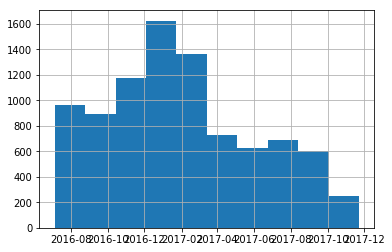

In [39]:
dat.Datum.hist()

In [40]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917 entries, 0 to 8916
Data columns (total 20 columns):
Unnamed: 0                                    8917 non-null int64
Datum                                         8917 non-null datetime64[ns]
Buchungsnummer                                8917 non-null int64
Kundennummer                                  8917 non-null int64
Miete                                         8917 non-null int64
Hausnation                                    8917 non-null object
Name1                                         8917 non-null object
Name2                                         61 non-null object
Adresse1                                      8917 non-null object
Adresse2                                      79 non-null object
LKZ                                           8917 non-null object
PLZ                                           8917 non-null object
Ort                                           8917 non-null object
Buchungskanal         